In [ ]:
'''This notebook allows you to build a time series model. Predict the daily behavior of the series in the next 3 months.'''

In [14]:
import pandas as pd
import numpy as np
import statsmodels 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [2]:
# Load data
data = pd.read_excel(r"C:\Users\Admin\WORK\Time_series_analysis\data\task_1_2.xlsx", sheet_name="Timeseries")
data = data.rename(columns={'Date': 'date', 'series1': 'series'})
data['date'] = pd.to_datetime(data['date'])                        # change to datetime object (datetime64)
data.set_index('date', inplace=True)                               # pick column "Date" how label (inplace=True  for don't creating new df)

In [100]:
data.iloc[1314]

series    4322.886728
Name: 2018-08-07 00:00:00, dtype: float64

In [3]:
mean1 = data.iloc[0:820].mean()
mean2 = data.iloc[821:].mean()
print(mean1)
print(mean2)
print("%:", ((mean2 - mean1) / mean1 * 100))

mean3 = data.iloc[0:820].std()
mean4 = data.iloc[821:].std()
print(mean3)
print(mean4)
print("%:", ((mean4 - mean3) / mean3 * 100))


series    3646.937261
dtype: float64
series    4062.189723
dtype: float64
%: series    11.386334
dtype: float64
series    1152.256384
dtype: float64
series    1285.014839
dtype: float64
%: series    11.521607
dtype: float64


In [99]:
# dataframe information
print(data)
print(data.describe())
print("\nКоличество нулевых значений в каждом столбце:")
print("None:", data.isnull().sum(), "\nNaN:", data.isna().sum())

                 series
date                   
2015-01-01  1006.699649
2015-01-02  3197.751826
2015-01-03  3217.491035
2015-01-04  2151.573759
2015-01-05  4243.929892
...                 ...
2019-06-26  4007.059387
2019-06-27  4836.106157
2019-06-28  4895.323783
2019-06-29  4086.016222
2019-06-30  3572.796793

[1642 rows x 1 columns]
             series
count   1642.000000
mean    3854.975154
std     1237.337605
min      236.870506
25%     3138.534200
50%     3632.014420
75%     4258.734299
max    12652.832842

Количество нулевых значений в каждом столбце:
None: series    0
dtype: int64 
NaN: series    0
dtype: int64


In [ ]:
data

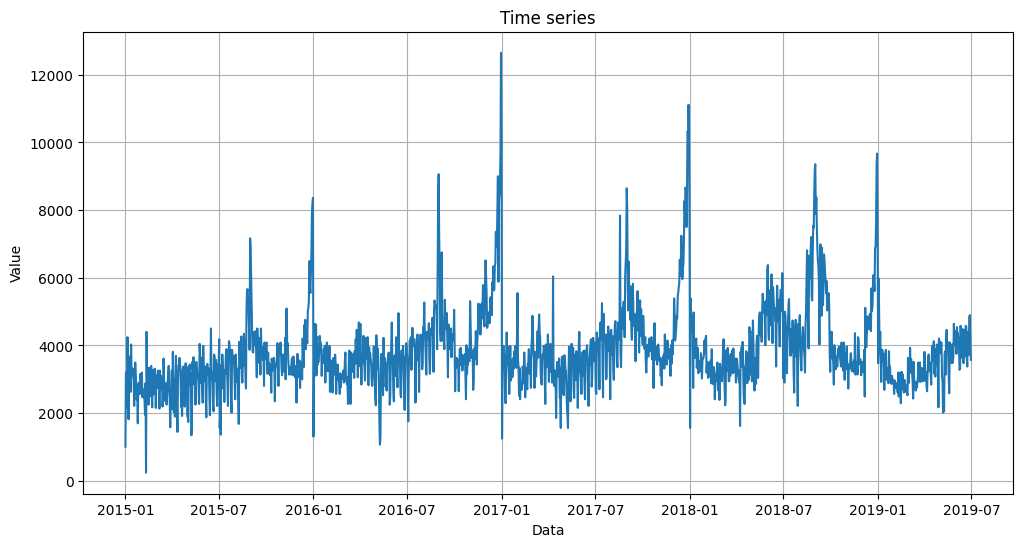

In [9]:
#visualization time series for checking of trend

plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title("Time series")
plt.xlabel("Data")
plt.ylabel("Value")
plt.grid()
plt.show()

In [10]:
# for estimating stationarity of time series
result = adfuller(data['series'])  
# print("ADF Statistic:", result[0])
# print("p-value:", result[1])


print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.496714
p-value: 0.000002
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


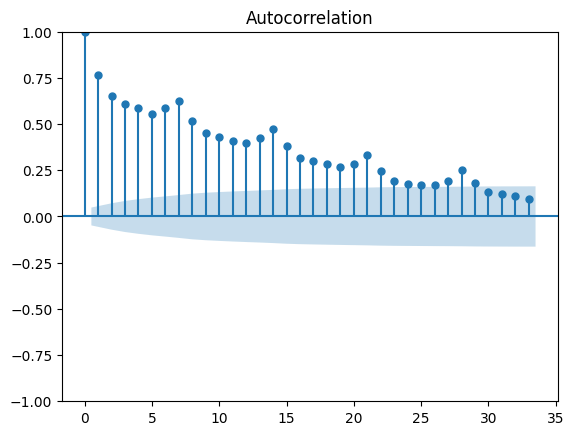

In [68]:
# check autocorrelation of data 
plot_acf(data)
plt.show()

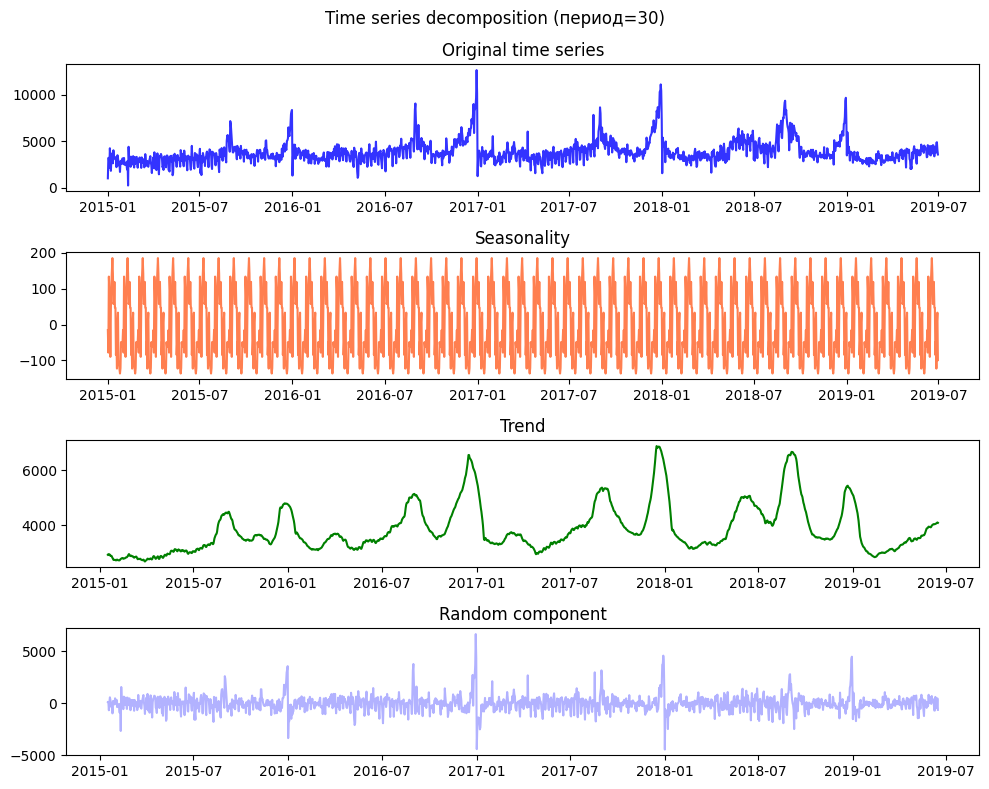

In [61]:
# decompose time series to component

def decompose(series, period):
    decomposition = seasonal_decompose(series, period=period, model='additive')
    
    fig, axs = plt.subplots(4, 1, figsize=(10, 8))

    axs[0].plot(series, color='blue', alpha=0.8)
    axs[0].set_title('Original time series')

    axs[1].plot(decomposition.seasonal, color='coral')
    axs[1].set_title('Seasonality')

    axs[2].plot(decomposition.trend, color='green')
    axs[2].set_title('Trend')

    axs[3].plot(decomposition.resid, color='blue', alpha=0.3)
    axs[3].set_title('Random component')

    plt.suptitle(f"Time series decomposition (период={period})")
    plt.tight_layout()
    plt.show()


decompose(data, period=30)

In [62]:
# model of time series
model = ARIMA(data, order=(1, 1, 1))  
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 series   No. Observations:                 1642
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -13225.682
Date:                Tue, 12 Aug 2025   AIC                          26457.363
Time:                        10:51:38   BIC                          26473.572
Sample:                    01-01-2015   HQIC                         26463.374
                         - 06-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3904      0.025     15.666      0.000       0.342       0.439
ma.L1         -0.8140      0.015    -53.577      0.000      -0.844      -0.784
sigma2      6.086e+05   1.04e+04     58.374      0.0

c:\Users\Admin\WORK\Time_series_analysis\a1_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\WORK\Time_series_analysis\a1_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\WORK\Time_series_analysis\a1_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


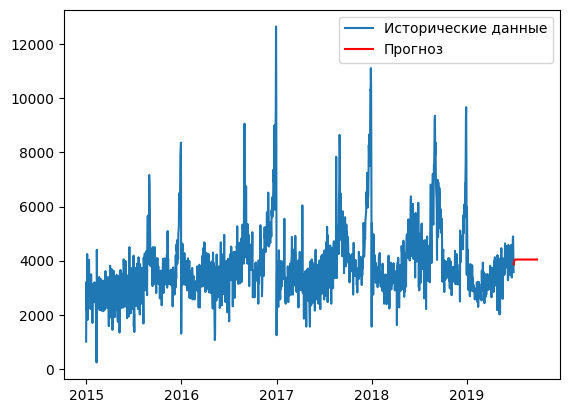

In [10]:
forecast = model_fit.forecast(steps=90)
plt.plot(data, label="Исторические данные")
plt.plot(forecast, label="Прогноз", color='red')
plt.legend()
plt.show()

In [6]:

# Разделим данные на обучающую и тестовую выборки
train = data[:-30]  # все, кроме последних 30 дней
test = data[-30:]

# Обучаем модель на train
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Прогнозируем на test
forecast = model_fit.forecast(steps=30)

# Считаем ошибки
mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}%") 

c:\Users\Admin\WORK\Time_series_analysis\A1_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\WORK\Time_series_analysis\A1_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\WORK\Time_series_analysis\A1_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


TypeError: got an unexpected keyword argument 'squared'

In [4]:
# разобьём данные на обучающую и тестовую выборки

# обучающая выборка будет включать данные до декабря 1959 года включительно
train = data[:'2018-08-07']

# тестовая выборка начнется с января 1960 года (по сути, один год)
test = data['2018-08-08':]


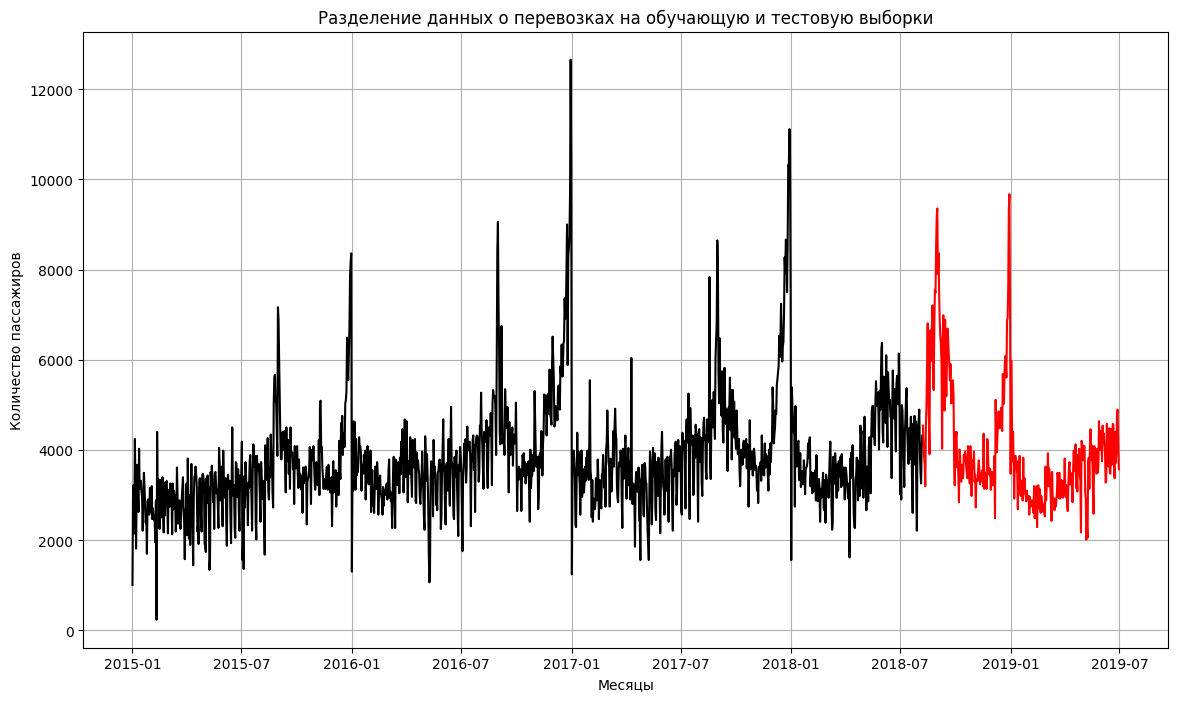

In [12]:
# выведем эти данные на графике
plt.figure(figsize=(14, 8))
plt.plot(train, color = "black")
plt.plot(test, color = "red")

# заголовок и подписи к осям
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()
     

In [6]:
# импортируем функцию для автоматического подбора параметров модели ARIMA
from pmdarima import auto_arima


# "погасим" предупреждения
import warnings
warnings.filterwarnings("ignore")

# настроим поиск параметров на обучающей выборке
parameter_search = auto_arima(train, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True,
                         d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True)           #

# выведем результат
print(parameter_search.summary())
     

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=22508.946, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=21693.473, Time=0.96 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=22507.061, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=22038.329, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=21566.706, Time=2.65 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.99 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=22257.748, Time=3.57 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=21551.693, Time=3.28 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=21694.131, Time=1.26 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=21243.103, Time=6.69 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.10 sec
 ARIMA(2,0,0)(2,1,2)[12] intercept 

In [7]:

     # принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

# импортируем класс модели
from statsmodels.tsa.statespace.sarimax import SARIMAX

# создадим объект этой модели
model = SARIMAX(train,
                order = (2, 0, 0),
                seasonal_order = (2, 1, 1, 12))

# применим метод fit
result = model.fit()

In [8]:
# мы можем посмотреть результат с помощью метода summary()
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               series   No. Observations:                 1315
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood              -10593.236
Date:                              Tue, 12 Aug 2025   AIC                          21198.471
Time:                                      12:24:50   BIC                          21229.506
Sample:                                  01-01-2015   HQIC                         21210.114
                                       - 08-07-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6475      0.019     33.275      0.000       0.609       0.686
ar.L2          0.16

In [9]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)

# и закончится в конце тестового
end = len(train) + len(test) - 1

# применим метод predict
predictions = result.predict(start, end)
predictions

2018-08-08    4194.937853
2018-08-09    4317.143505
2018-08-10    4366.838681
2018-08-11    4128.770729
2018-08-12    3929.404978
                 ...     
2019-06-26    3675.155215
2019-06-27    3687.125460
2019-06-28    3762.838255
2019-06-29    3848.187196
2019-06-30    3855.001449
Freq: D, Name: predicted_mean, Length: 327, dtype: float64

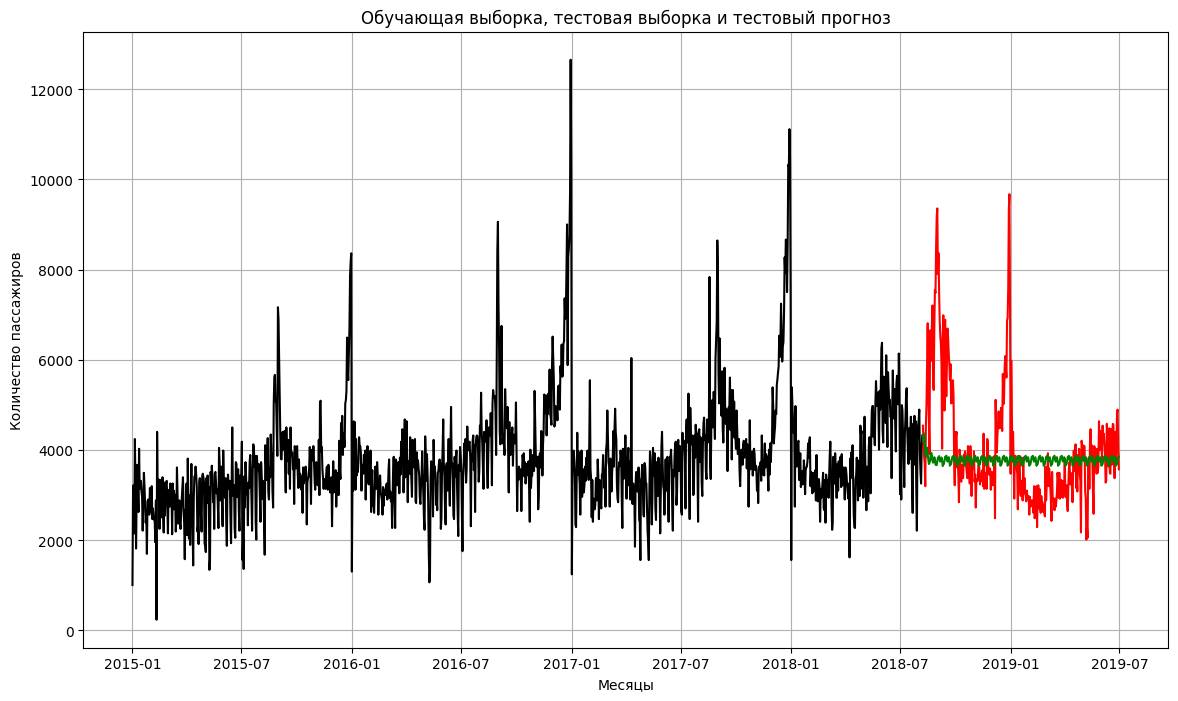

In [13]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.figure(figsize=(14, 8))
plt.plot(train, color = 'black')
plt.plot(test, color = 'red')
plt.plot(predictions, color = 'green')

# заголовок и подписи к осям
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [15]:
# импортируем метрику
from sklearn.metrics import mean_squared_error

# рассчитаем MSE
print(mean_squared_error(test, predictions))

# и RMSE
print(np.sqrt(mean_squared_error(test, predictions)))

1845044.468903052
1358.3241398514024


In [16]:
# прогнозный период начнется с конца имеющихся данных
start = len(data)

# и закончится 36 месяцев спустя
end = (len(data) - 1) + 90

# теперь построим прогноз на три года вперед
forecast = result.predict(start, end)

# посмотрим на весь 1963 год
forecast[-12:]

2019-09-17    3650.402045
2019-09-18    3675.155215
2019-09-19    3687.125460
2019-09-20    3762.838255
2019-09-21    3848.187196
2019-09-22    3855.001449
2019-09-23    3871.670763
2019-09-24    3777.641259
2019-09-25    3741.611384
2019-09-26    3779.979023
2019-09-27    3840.535509
2019-09-28    3777.441577
Freq: D, Name: predicted_mean, dtype: float64

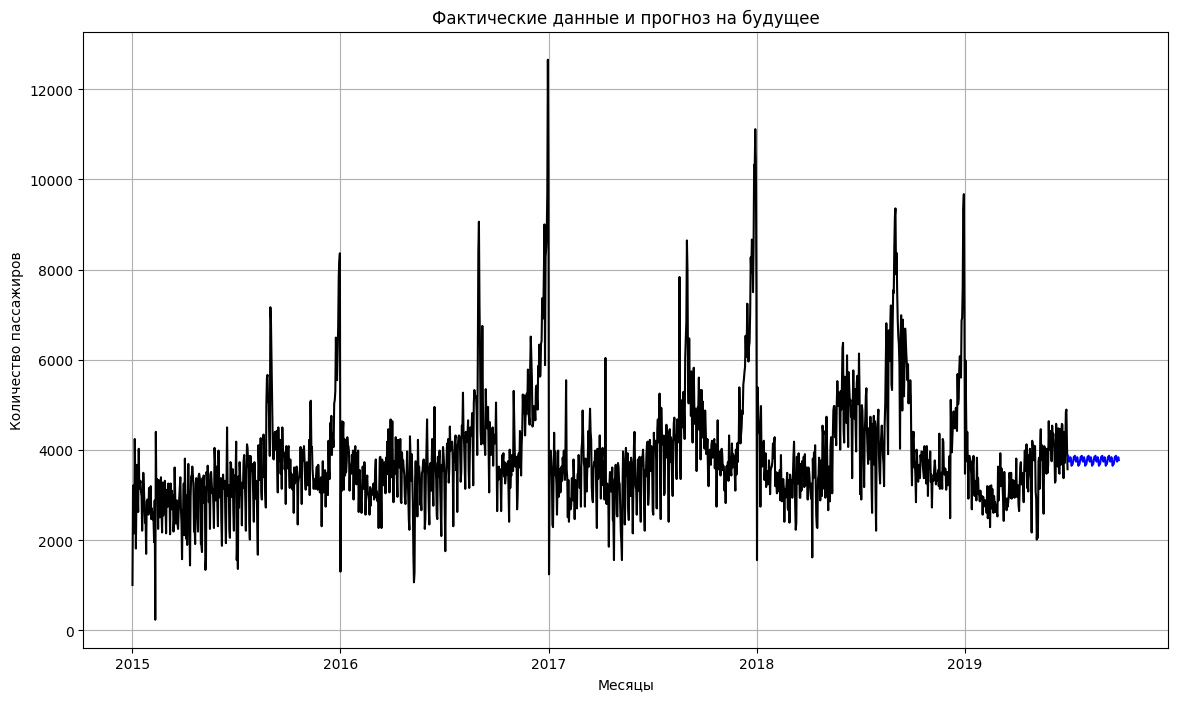

In [18]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.figure(figsize=(14, 8))
plt.plot(data, color = 'black')
plt.plot(forecast, color = 'blue')

# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()